In [1]:
# Load packages
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import pickle

# Activity 6

Load raw case study data

In [2]:
df_orig = pd.read_excel(
    '../Data/default_of_credit_card_clients__courseware_version_1_21_19.xls')

Repeat previous data cleaning steps: remove samples where all features and the response are zero

In [3]:
df_zero_mask = df_orig == 0
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)
sum(feature_zero_mask)
# 315

315

In [4]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
print(df_clean.shape)
# (29685, 25)
print(df_clean['ID'].nunique())
# 29685

(29685, 25)
29685


Repeat previous data cleaning steps: adjust undocumented feature values

In [5]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean['EDUCATION'].value_counts()
# 2    13884
# 1    10474
# 3     4867
# 4      460
# Name: EDUCATION, dtype: int64

2    13884
1    10474
3     4867
4      460
Name: EDUCATION, dtype: int64

In [6]:
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)
df_clean['MARRIAGE'].value_counts()
# 2    15810
# 1    13503
# 3      372
# Name: MARRIAGE, dtype: int64

2    15810
1    13503
3      372
Name: MARRIAGE, dtype: int64

Now instead of throwing away samples with missing data, we fill them with `np.nan` which XGBoost can work with. Start by making a separate dataframe with just these values.

In [7]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'
sum(missing_pay_1_mask)
# 3021

3021

In [8]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()
df_missing_pay_1.shape

(3021, 25)

In [9]:
df_missing_pay_1['PAY_1'].head(3)

17    Not available
28    Not available
29    Not available
Name: PAY_1, dtype: object

Load cleaned data that had missing values removed:

In [10]:
df = pd.read_csv('../Data/Chapter_1_cleaned_data.csv')

In [11]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school',
                   'high school', 'none', 'others', 'university']
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Replicate the train/test split from earlier

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values,
                 df['default payment next month'].values,
                 test_size=0.2, random_state=24)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# (21331, 17)
# (5333, 17)
# (21331,)
# (5333,)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [14]:
df_missing_pay_1.shape

(3021, 25)

Make a similar train/test split with the dataframe that has only missing values, after changing `'Not available'` to `np.nan`. Then combine the non-missing and missing data for the training and testing data sets.

In [15]:
#Copy the data frame with missing PAY_1 and assign imputed values
df_fill_pay_1_filled = df_missing_pay_1.copy()
df_fill_pay_1_filled['PAY_1'] = np.nan

#Split imputed data in to training and testing, using the same
#80/20 split we have used for the data with non-missing PAY_1
X_fill_pay_1_train, X_fill_pay_1_test,\
y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_filled[features_response[:-1]],
    df_fill_pay_1_filled['default payment next month'],
test_size=0.2, random_state=24)

#Concatenate the imputed data with the array of non-missing data
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

Define a validation set to train XGBoost with early stopping.

In [16]:
from sklearn.model_selection import train_test_split
X_train_2, X_val_2, y_train_2, y_val_2 = \
train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=24)

In [17]:
xgb_model_4 = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide')

In [18]:
max_leaves_values = list(range(5,205,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[180, 185, 190, 195, 200]


In [19]:
eval_set_2 = [(X_train_2, y_train_2), (X_val_2, y_val_2)]

In [20]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model_4.set_params(**{'max_leaves':max_leaves})
    xgb_model_4.fit(X_train_2, y_train_2, eval_set=eval_set_2,
                  eval_metric='auc',
                  verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba = xgb_model_4.predict_proba(X_val_2)[:,1]
    val_aucs.append(roc_auc_score(y_val_2, val_set_pred_proba))

CPU times: user 2min 45s, sys: 24.1 s, total: 3min 9s
Wall time: 2min 56s


In [21]:
max_leaves_df_2 = \
pd.DataFrame({'Max leaves':max_leaves_values,
              'Validation AUC':val_aucs})

<AxesSubplot:xlabel='Max leaves'>

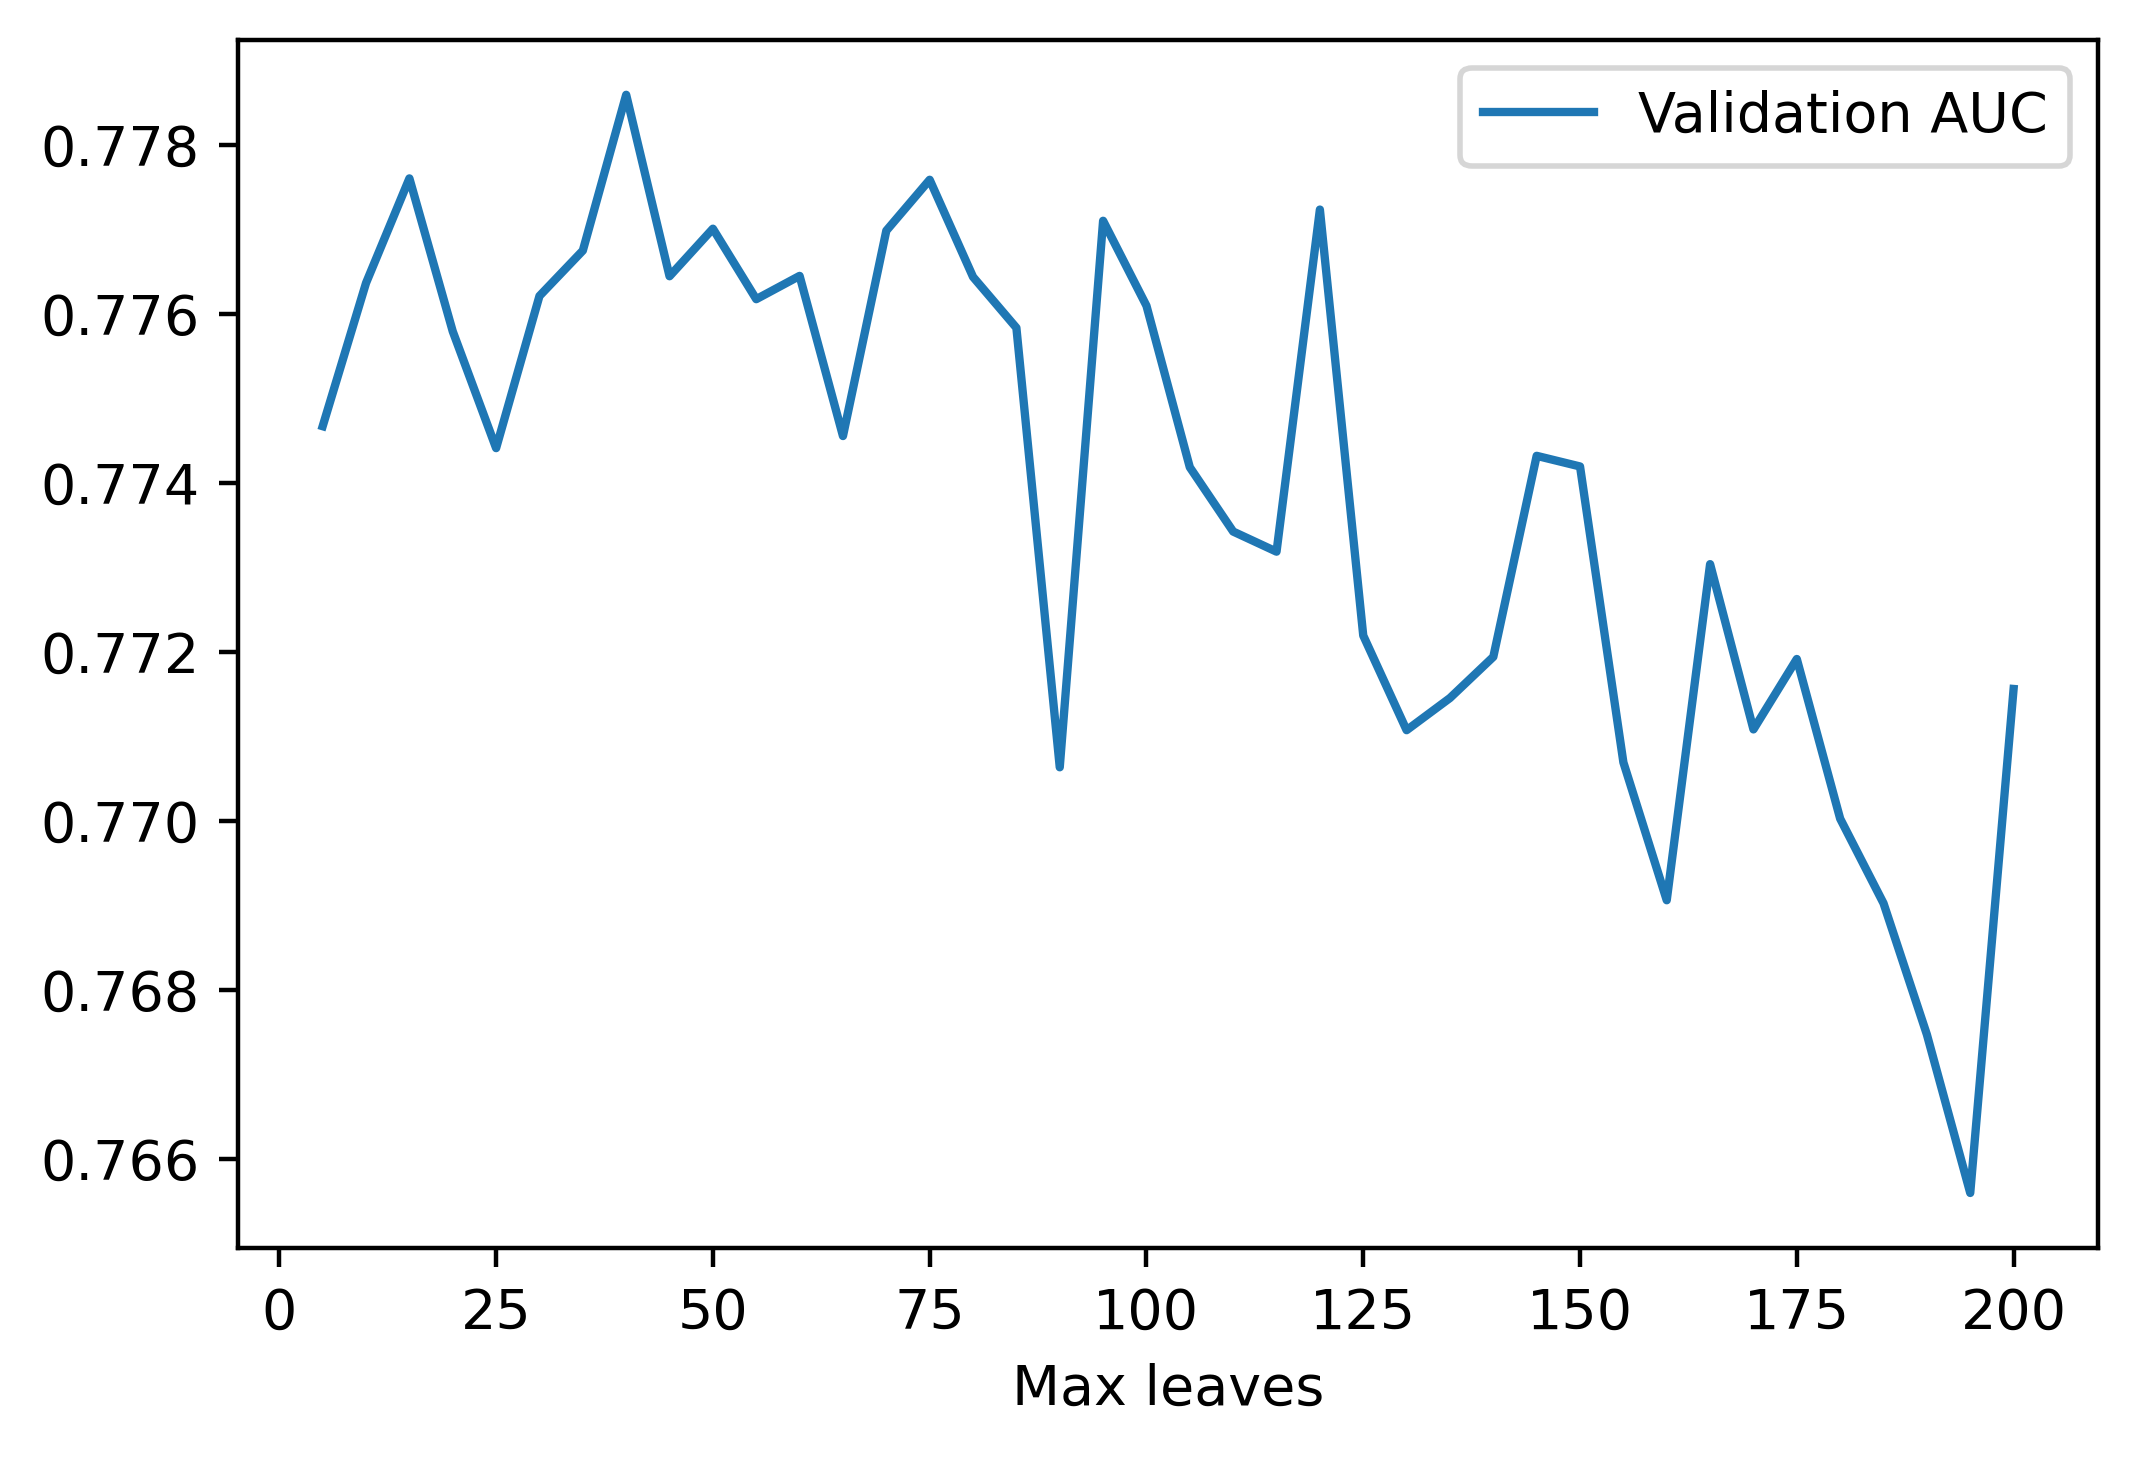

In [22]:
mpl.rcParams['figure.dpi'] = 400
max_leaves_df_2.set_index('Max leaves').plot()

In [23]:
max_auc_2 = max_leaves_df_2['Validation AUC'].max()
max_auc_2
# 0.7785918508068121 (learning rate 0.1)
# 0.7783846497029288 (learning rate 0.05)

0.7785918508068121

In [24]:
max_ix_2 = max_leaves_df_2['Validation AUC'] == max_auc_2
max_leaves_df_2[max_ix_2]

,Max leaves,Validation AUC
7,40,0.778592


Retrain with optimal hyperparameter.

In [25]:
xgb_model_4.set_params(**{'max_leaves':40})
xgb_model_4.fit(X_train_2, y_train_2, eval_set=eval_set_2,
              eval_metric='auc',
              verbose=False, early_stopping_rounds=30)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=0, max_leaves=40, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [26]:
# X_val_2

In [27]:
X_val_2_df = pd.DataFrame(data=X_val_2, columns=features_response[:-1])

In [28]:
# X_val_2_df.head(40)

SHAP summary

In [29]:
%time explainer_2 = shap.explainers.Tree(xgb_model_4, data=X_val_2_df)

CPU times: user 263 ms, sys: 4.11 ms, total: 267 ms
Wall time: 272 ms


In [30]:
%time shap_values_2 = explainer_2(X_val_2_df)

 96%|=================== | 4560/4750 [00:15<00:00]       

CPU times: user 14.7 s, sys: 95.6 ms, total: 14.8 s
Wall time: 15.5 s


In [31]:
shap_values_2.values.shape

(4750, 17)

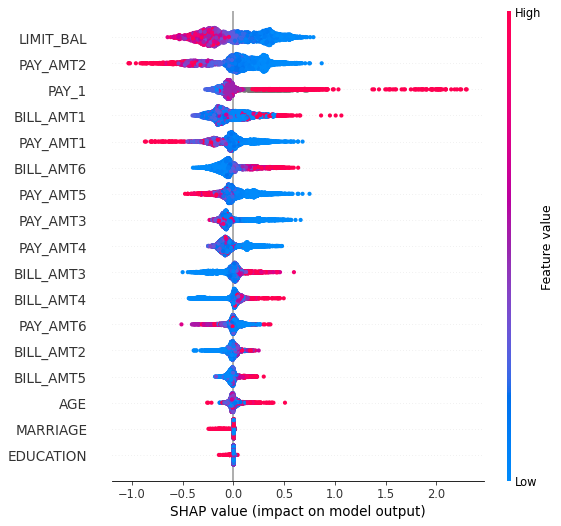

CPU times: user 1.8 s, sys: 63.1 ms, total: 1.86 s
Wall time: 1.98 s


In [32]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values_2.values, X_val_2_df)

Use the feature of SHAP that looks for the strongest interaction effect.

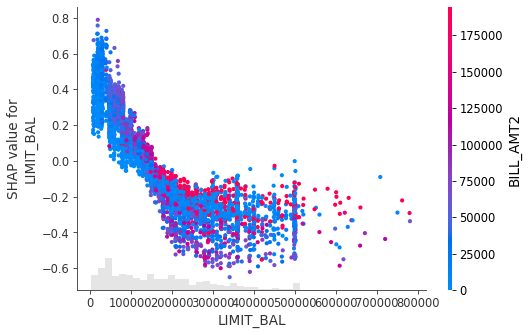

In [33]:
shap.plots.scatter(shap_values_2[:,'LIMIT_BAL'],
                   color=shap_values_2)

Save the features and response name list, training and testing sets, and trained model to refer to and analyze later.

In [34]:
# with open('../Data/xgb_model_w_data.pkl', 'wb') as f:
#     pickle.dump([features_response,
#                  X_train_all, y_train_all,
#                  X_test_all, y_test_all,
#                  xgb_model_4], f)